In [38]:
#%%
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.style as style
style.use('fivethirtyeight')
import seaborn as sns
import os
from matplotlib.ticker import FuncFormatter


In [90]:

train = pd.read_csv('./raw_data/train.csv')

In [82]:
train.memory_usage(deep=True)

Index                                   128
row_id                            159060848
timestamp                         159060848
user_id                           159060848
content_id                        159060848
content_type_id                   159060848
task_container_id                 159060848
user_answer                       159060848
answered_correctly                159060848
prior_question_elapsed_time       159060848
prior_question_had_explanation    706713372
dtype: int64

In [83]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19882606 entries, 0 to 19882605
Data columns (total 10 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   row_id                          int64  
 1   timestamp                       int64  
 2   user_id                         int64  
 3   content_id                      float64
 4   content_type_id                 float64
 5   task_container_id               float64
 6   user_answer                     float64
 7   answered_correctly              float64
 8   prior_question_elapsed_time     float64
 9   prior_question_had_explanation  object 
dtypes: float64(6), int64(3), object(1)
memory usage: 1.5+ GB


In [84]:
train = train.dropna()
train['user_id'] = train['user_id'].astype('int32')
train['content_id'] = train['content_id'].astype('int16')
train['task_container_id'] = train['task_container_id'].astype('int16')
train['user_answer'] = train['user_answer'].astype('int8')
train['answered_correctly'] = train['answered_correctly'].astype('int8')
train['prior_question_elapsed_time'] = train['prior_question_elapsed_time'].astype('float32')
train['prior_question_had_explanation'] = train['prior_question_had_explanation'].astype('boolean')

In [ ]:
train.memory_usage(deep=True)

In [86]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19417163 entries, 1 to 19882604
Data columns (total 10 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   row_id                          int64  
 1   timestamp                       int64  
 2   user_id                         int32  
 3   content_id                      int16  
 4   content_type_id                 float64
 5   task_container_id               int16  
 6   user_answer                     int8   
 7   answered_correctly              int8   
 8   prior_question_elapsed_time     float32
 9   prior_question_had_explanation  boolean
dtypes: boolean(1), float32(1), float64(1), int16(2), int32(1), int64(2), int8(2)
memory usage: 888.8 MB


In [59]:
%%time

questions = pd.read_csv('./raw_data/questions.csv')
lectures = pd.read_csv('./raw_data/lectures.csv')
example_test = pd.read_csv('./raw_data/example_test.csv')

Wall time: 13 ms


In [93]:
train.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692.0,0.0,1.0,3.0,1.0,NaN,NaN
1,1,56943,115,5716.0,0.0,2.0,2.0,1.0,37000.0,False
2,2,118363,115,128.0,0.0,0.0,0.0,1.0,55000.0,False
3,3,131167,115,7860.0,0.0,3.0,0.0,1.0,19000.0,False
4,4,137965,115,7922.0,0.0,4.0,1.0,1.0,11000.0,False


In [92]:
print(f'We have {train.user_id.nunique()} unique users in our train set')

We have 77787 unique users in our train set


In [91]:
train.content_type_id.value_counts()

0.0    19494736
1.0      387869
Name: content_type_id, dtype: int64

In [94]:
print(f'We have {train.content_id.nunique()} content ids in our train set, of which {train[train.content_type_id == False].content_id.nunique()} are questions.')

We have 13768 content ids in our train set, of which 13517 are questions.


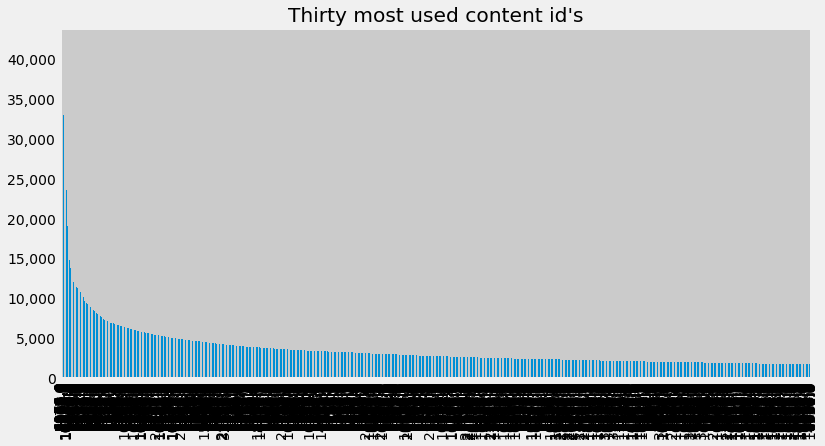

In [98]:
cids = train.content_id.value_counts()[:30]

fig = plt.figure(figsize=(12,6))
ax = cids.plot.bar()
plt.title("Thirty most used content id's")
plt.xticks(rotation=90)
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ','))) #add thousands separator
plt.show()

In [99]:
print(f'We have {train.task_container_id.nunique()} unique Batches of questions or lectures.')

We have 10000 unique Batches of questions or lectures.


In [100]:
train.user_answer.value_counts()

 0.0    5537785
 1.0    5293591
 3.0    5126514
 2.0    3536846
-1.0     387869
Name: user_answer, dtype: int64

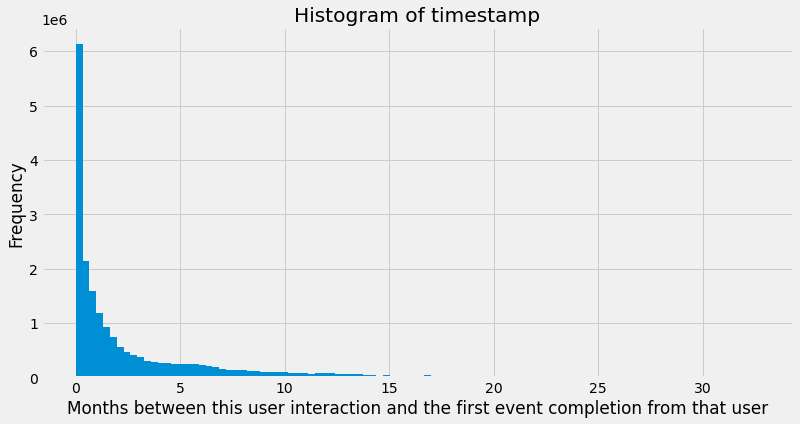

In [101]:
#1 year = 31536000000 ms
ts = train['timestamp']/(31536000000/12)
fig = plt.figure(figsize=(12,6))
ts.plot.hist(bins=100)
plt.title("Histogram of timestamp")
plt.xticks(rotation=0)
plt.xlabel("Months between this user interaction and the first event completion from that user")
plt.show()

In [102]:
print(f'Of the {train.user_id.nunique()} users in train we have {train[train.timestamp == 0].user_id.nunique()} users with a timestamp zero row.')

Of the 77787 users in train we have 77786 users with a timestamp zero row.


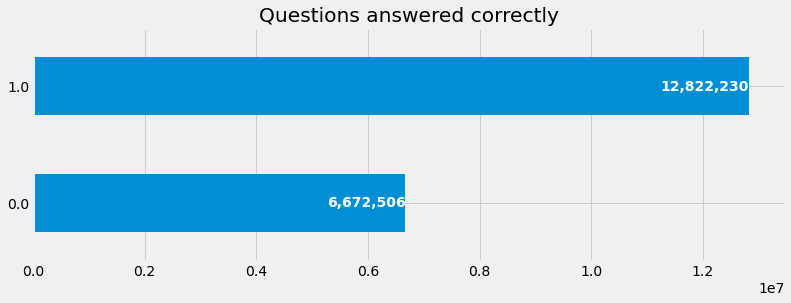

In [103]:
correct = train[train.answered_correctly != -1].answered_correctly.value_counts(ascending=True)

fig = plt.figure(figsize=(12,4))
correct.plot.barh()
for i, v in zip(correct.index, correct.values):
    plt.text(v, i, '{:,}'.format(v), color='white', fontweight='bold', fontsize=14, ha='right', va='center')
plt.title("Questions answered correctly")
plt.xticks(rotation=0)
plt.show()

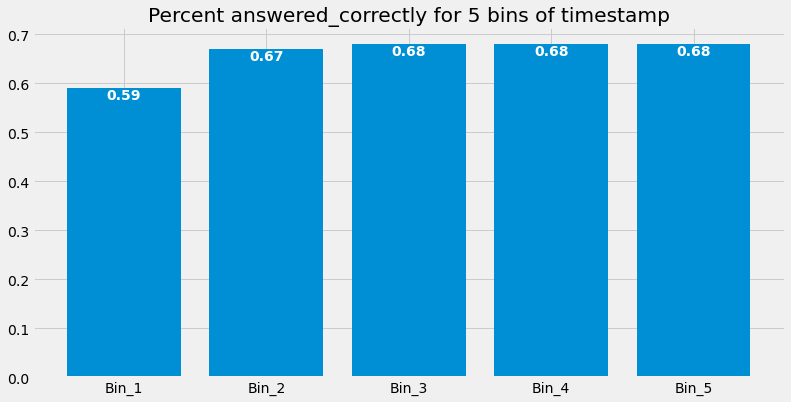

In [104]:
bin_labels_5 = ['Bin_1', 'Bin_2', 'Bin_3', 'Bin_4', 'Bin_5']
train['ts_bin'] = pd.qcut(train['timestamp'], q=5, labels=bin_labels_5)

#make function that can also be used for other fields
def correct(field):
    correct = train[train.answered_correctly != -1].groupby([field, 'answered_correctly'], as_index=False).size()
    correct = correct.pivot(index= field, columns='answered_correctly', values='size')
    correct['Percent_correct'] = round(correct.iloc[:,1]/(correct.iloc[:,0] + correct.iloc[:,1]),2)
    correct = correct.sort_values(by = "Percent_correct", ascending = False)
    correct = correct.iloc[:,2]
    return(correct)

bins_correct = correct("ts_bin")
bins_correct = bins_correct.sort_index()

fig = plt.figure(figsize=(12,6))
plt.bar(bins_correct.index, bins_correct.values)
for i, v in zip(bins_correct.index, bins_correct.values):
    plt.text(i, v, v, color='white', fontweight='bold', fontsize=14, va='top', ha='center')
plt.title("Percent answered_correctly for 5 bins of timestamp")
plt.xticks(rotation=0)
plt.show()

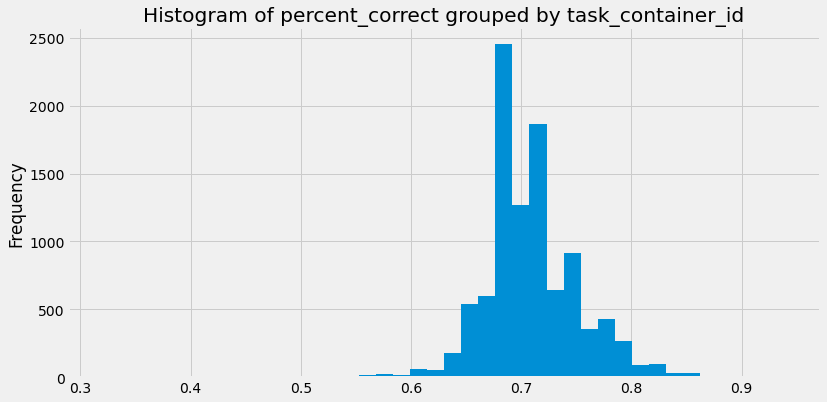

In [105]:
task_id_correct = correct("task_container_id")

fig = plt.figure(figsize=(12,6))
task_id_correct.plot.hist(bins=40)
plt.title("Histogram of percent_correct grouped by task_container_id")
plt.xticks(rotation=0)
plt.show()

In [106]:
user_percent = train[train.answered_correctly != -1].groupby('user_id')['answered_correctly'].agg(Mean='mean', Answers='count')
print(f'the highest number of questions answered by a user is {user_percent.Answers.max()}')

the highest number of questions answered by a user is 15859


In [107]:
content_percent = train[train.answered_correctly != -1].groupby('content_id')['answered_correctly'].agg(Mean='mean', Answers='count')
print(f'The highest number of questions asked by content_id is {content_percent.Answers.max()}.')
print(f'Of {len(content_percent)} content_ids, {len(content_percent[content_percent.Answers > 25000])} content_ids had more than 25,000 questions asked.')

The highest number of questions asked by content_id is 41892.
Of 13517 content_ids, 31 content_ids had more than 25,000 questions asked.


prior_question_had_explanation
False     1799668
True     17617495
NaN         77573
Name: (answered_correctly, count), dtype: int64


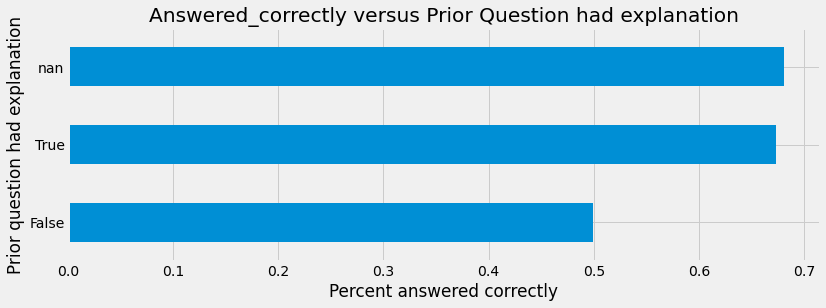

In [109]:
pq = train[train.answered_correctly != -1].groupby(['prior_question_had_explanation'], dropna=False).agg({'answered_correctly': ['mean', 'count']})
#pq.index = pq.index.astype(str)
print(pq.iloc[:,1])
pq = pq.iloc[:,0]

fig = plt.figure(figsize=(12,4))
pq.plot.barh()
# for i, v in zip(pq.index, pq.values):
#     plt.text(v, i, round(v,2), color='white', fontweight='bold', fontsize=14, ha='right', va='center')
plt.title("Answered_correctly versus Prior Question had explanation")
plt.xlabel("Percent answered correctly")
plt.ylabel("Prior question had explanation")
plt.xticks(rotation=0)
plt.show()

## QUESTIONS

In [110]:
questions.head()

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38


In [111]:
questions.shape

(13523, 5)

In [112]:
questions[questions.tags.isna()]

,question_id,bundle_id,correct_answer,part,tags
10033,10033,10033,2,6,NaN


In [113]:
train.query('content_id == "10033" and answered_correctly != -1')

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,ts_bin


In [114]:
questions['tags'] = questions['tags'].astype(str)

tags = [x.split() for x in questions[questions.tags != "nan"].tags.values]
tags = [item for elem in tags for item in elem]
tags = set(tags)
tags = list(tags)
print(f'There are {len(tags)} different tags')

There are 188 different tags


In [115]:
tags_list = [x.split() for x in questions.tags.values]
questions['tags'] = tags_list
questions.head()

correct = train[train.answered_correctly != -1].groupby(["content_id", 'answered_correctly'], as_index=False).size()
correct = correct.pivot(index= "content_id", columns='answered_correctly', values='size')
correct.columns = ['Wrong', 'Right']
correct = correct.fillna(0)
correct[['Wrong', 'Right']] = correct[['Wrong', 'Right']].astype(int)
questions = questions.merge(correct, left_on = "question_id", right_on = "content_id", how = "left")
questions.head()

,question_id,bundle_id,correct_answer,part,tags,Wrong,Right
0,0,0,0,1,"[51, 131, 162, 38]",128.0,1263.0
1,1,1,1,1,"[131, 36, 81]",154.0,1306.0
2,2,2,0,1,"[131, 101, 162, 92]",3930.0,4920.0
3,3,3,0,1,"[131, 149, 162, 29]",1011.0,3493.0
4,4,4,3,1,"[131, 5, 162, 38]",2373.0,3885.0


In [116]:
%%time

tags_df = pd.DataFrame()
for x in range(len(tags)):
    df = questions[questions.tags.apply(lambda l: tags[x] in l)]
    df1 = df.agg({'Wrong': ['sum'], 'Right': ['sum']})
    df1['Total_questions'] = df1.Wrong + df1.Right
    df1['Question_ids_with_tag'] = len(df)
    df1['tag'] = tags[x]
    df1 = df1.set_index('tag')
    tags_df = tags_df.append(df1)

tags_df[['Wrong', 'Right', 'Total_questions']] = tags_df[['Wrong', 'Right', 'Total_questions']].astype(int)
tags_df['Percent_correct'] = tags_df.Right/tags_df.Total_questions
tags_df = tags_df.sort_values(by = "Percent_correct")

tags_df.head()

Wall time: 993 ms


,Wrong,Right,Total_questions,Question_ids_with_tag,Percent_correct
tag,,,,,
24,31027,19424,50451,17,0.385007
19,33959,26634,60593,57,0.439556
23,51326,40389,91715,11,0.440375
151,53712,51793,105505,16,0.490906
167,33433,33827,67260,11,0.502929


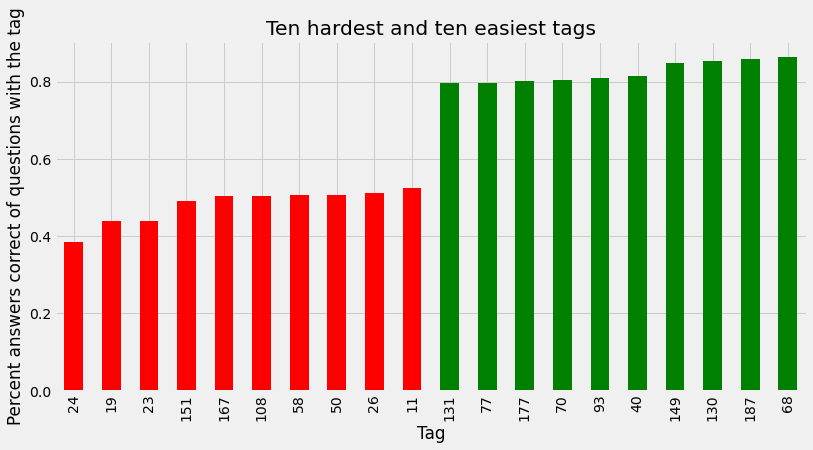

In [117]:
select_rows = list(range(0,10)) + list(range(178, len(tags_df)))
tags_select = tags_df.iloc[select_rows,4]

fig = plt.figure(figsize=(12,6))
x = tags_select.index
y = tags_select.values
clrs = ['red' if y < 0.6 else 'green' for y in tags_select.values]
tags_select.plot.bar(x, y, color=clrs)
plt.title("Ten hardest and ten easiest tags")
plt.xlabel("Tag")
plt.ylabel("Percent answers correct of questions with the tag")
plt.xticks(rotation=90)
plt.show()

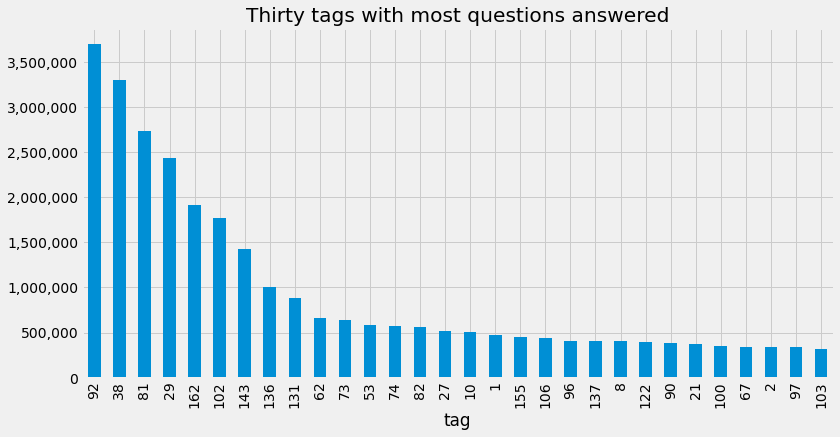

In [118]:
tags_select = tags_df.sort_values(by = "Total_questions", ascending = False).iloc[:30,:]
tags_select = tags_select["Total_questions"]

fig = plt.figure(figsize=(12,6))
ax = tags_select.plot.bar()
plt.title("Thirty tags with most questions answered")
plt.xticks(rotation=90)
plt.ticklabel_format(style='plain', axis='y')
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ','))) #add thousands separator
plt.show()

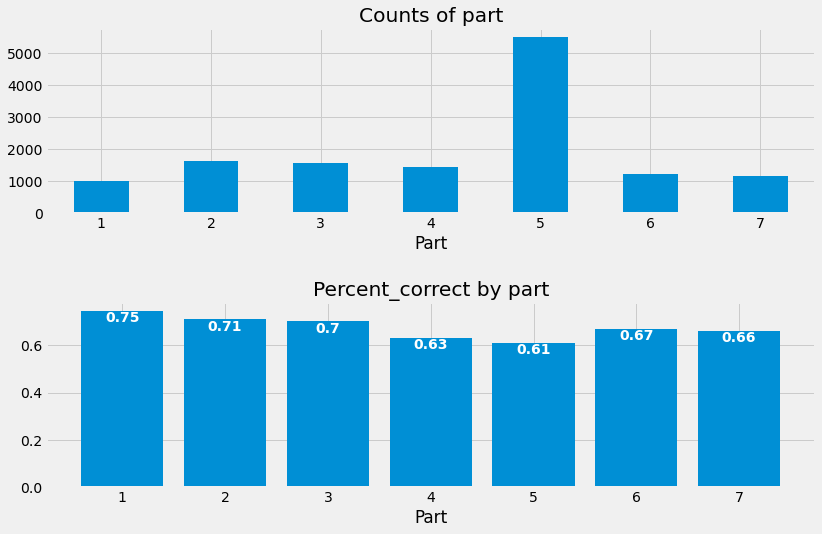

In [120]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
ax1 = questions.groupby("part").count()['question_id'].plot.bar()
plt.title("Counts of part")
plt.xlabel("Part")
plt.xticks(rotation=0)

part = questions.groupby('part').agg({'Wrong': ['sum'], 'Right': ['sum']})
part['Percent_correct'] = part.Right/(part.Right + part.Wrong)
part = part.iloc[:,2]

ax2 = fig.add_subplot(212)
plt.bar(part.index, part.values)
for i, v in zip(part.index, part.values):
    plt.text(i, v, round(v,2), color='white', fontweight='bold', fontsize=14, va='top', ha='center')

plt.title("Percent_correct by part")
plt.xlabel("Part")
plt.xticks(rotation=0)
plt.tight_layout(pad=2)
plt.show()

## LECTURES

In [121]:
lectures.head()

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question


In [122]:
print(f'There are {lectures.shape[0]} lecture_ids.')

There are 418 lecture_ids.


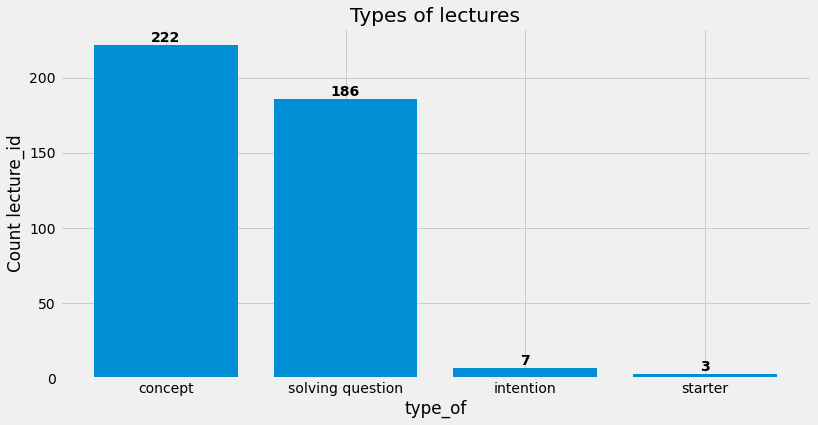

In [123]:
lect_type_of = lectures.type_of.value_counts()

fig = plt.figure(figsize=(12,6))
plt.bar(lect_type_of.index, lect_type_of.values)
for i, v in zip(lect_type_of.index, lect_type_of.values):
    plt.text(i, v, v, color='black', fontweight='bold', fontsize=14, va='bottom', ha='center')
plt.title("Types of lectures")
plt.xlabel("type_of")
plt.ylabel("Count lecture_id")
plt.xticks(rotation=0)
plt.show()

False    48186
True     29600
Name: Watches_lecture, dtype: int64


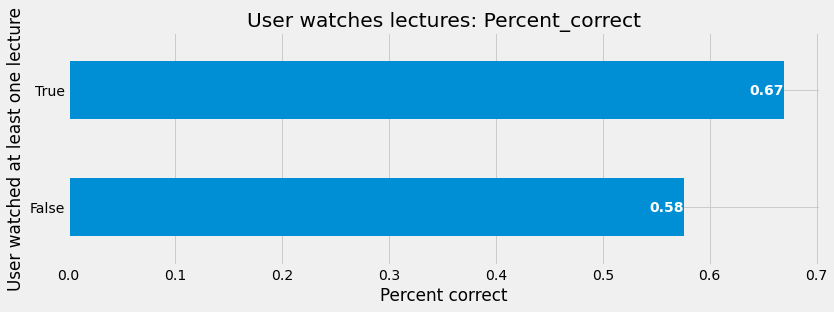

In [127]:
user_lect = train.groupby(["user_id", "answered_correctly"]).size().unstack()
user_lect.columns = ['Lecture', 'Wrong', 'Right']
user_lect['Lecture'] = user_lect['Lecture'].fillna(0)
user_lect = user_lect.astype('Int64')
user_lect['Watches_lecture'] = np.where(user_lect.Lecture > 0, True, False)

watches_l = user_lect.groupby("Watches_lecture").agg({'Wrong': ['sum'], 'Right': ['sum']})
print(user_lect.Watches_lecture.value_counts())

watches_l['Percent_correct'] = watches_l.Right/(watches_l.Right + watches_l.Wrong)

watches_l = watches_l.iloc[:,2]

fig = plt.figure(figsize=(12,4))
watches_l.plot.barh()
for i, v in zip(watches_l.index, watches_l.values):
    plt.text(v, i, round(v,2), color='white', fontweight='bold', fontsize=14, ha='right', va='center')

plt.title("User watches lectures: Percent_correct")
plt.xlabel("Percent correct")
plt.ylabel("User watched at least one lecture")
plt.xticks(rotation=0)
plt.show()

In [128]:
batch_lect = train.groupby(["task_container_id", "answered_correctly"]).size().unstack()
batch_lect.columns = ['Lecture', 'Wrong', 'Right']
batch_lect['Lecture'] = batch_lect['Lecture'].fillna(0)
batch_lect = batch_lect.astype('Int64')
batch_lect['Percent_correct'] = batch_lect.Right/(batch_lect.Wrong + batch_lect.Right)
batch_lect['Percent_lecture'] = batch_lect.Lecture/(batch_lect.Lecture + batch_lect.Wrong + batch_lect.Right)
batch_lect = batch_lect.sort_values(by = "Percent_lecture", ascending = False)

print(f'The highest number of lectures watched within a single task_container_id is {batch_lect.Lecture.max()}.')

The highest number of lectures watched within a single task_container_id is 1012.


In [129]:
batch_lect.head()

,Lecture,Wrong,Right,Percent_correct,Percent_lecture
task_container_id,,,,,
9551.0,3,9,26,0.742857,0.078947
9596.0,3,13,23,0.638889,0.076923
9034.0,3,15,37,0.711538,0.054545
9736.0,2,16,19,0.542857,0.054054
9651.0,2,13,22,0.628571,0.054054
